In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from dask import dataframe as dd
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()
from multiprocessing import cpu_count
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Chapter 5 - Fractionally Differentiated Features

## 5.1 -  Generate a time series from an IID Gaussian random process. This is a memory-less, stationary series.

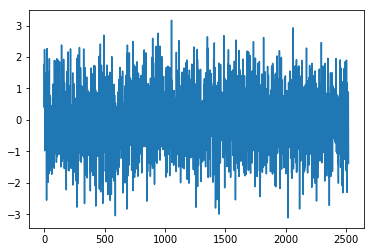

In [5]:
np.random.seed(0)

N = 252 * 10
s = pd.Series(np.random.randn(N))
s.plot()

### (a) Compute the ADF statistic on this series. Find p-value.
- Answer: p-value is 0.

In [27]:
# Returns
# 0) adf : Test statistic
# 1) pvalue 
# 2) usedlag 
# 3) number of observations used for the ADF
# 4) critical values
# 5) icbest: The maximized information creterion if autolag is not None

adf = lambda s: sm.tsa.stattools.adfuller(s)
p_val = lambda s: sm.tsa.stattools.adfuller(s)[1]
res = adf(s);
p = res[1]
res, p

((-50.80332180276015,
  0.0,
  0,
  2519,
  {'1%': -3.4329486408391174,
   '5%': -2.8626880695259413,
   '10%': -2.567381161224712},
  6950.968131407137),
 0.0)

In [28]:
# p-value == 0

res

(-50.80332180276015,
 0.0,
 0,
 2519,
 {'1%': -3.4329486408391174,
  '5%': -2.8626880695259413,
  '10%': -2.567381161224712},
 6950.968131407137)

### (b) Compute the cumulative sum of the observations. This is a non-stationary series without memory.
- compute the cumulative sum of the observations (cmsm).
- This is a non-stationary series (p-value = 0.57)

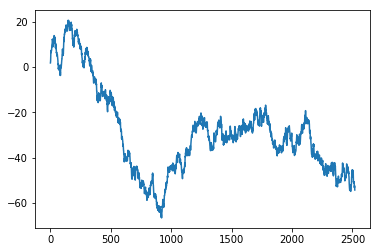

In [25]:
cmsm = pd.Series(s).cumsum()
cmsm.plot()

In [29]:
# p-value = 0.57 which means non-stationary.

adf_cmsm = lambda s: sm.tsa.stattools.adfuller(cmsm)
p_val_cmsm = lambda s: sm.tsa.stattools.adfuller(cmsm)[1]
res_cmsm = adf(cmsm);
p_cmsm = res_cmsm[1]
res_cmsm, p_cmsm

((-1.4245647267923265,
  0.5704444806659957,
  0,
  2519,
  {'1%': -3.4329486408391174,
   '5%': -2.8626880695259413,
   '10%': -2.567381161224712},
  6948.205809519549),
 0.5704444806659957)

### (i) What is the order of integration of this cumulative series?
- zero order differential p-value: 0.57
- 1st order differential p-value: 0.0
- 2nd order differential p-value: 0.0
- 3rd order differential p-value: 0.0

In [33]:
# differenciation with 0, 1, 2, 3, 4 
orders = [0, 1, 2, 3, 4]

for o in orders:
    diff_ = np.diff(cmsm, o)
    print('=======================')
    print(f'order: {o}, pVal: {p_val(diff_)}')

order: 0, pVal: 0.5704444806659957
order: 1, pVal: 0.0
order: 2, pVal: 7.347529850655982e-30
order: 3, pVal: 0.0
order: 4, pVal: 0.0


### (ii) compute the ADF statistic on this series. What is the p-value?
- 0.57

In [34]:
p_val(cmsm)

0.5704444806659957

### (c) Differentiate the series twice. (2nd order of diff). What is the p-value of this over-differentiated series?
- 2nd order differential p-value: 0.0

In [35]:
p_val(np.diff(cmsm, 2))

7.347529850655982e-30

## 5.2 - Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

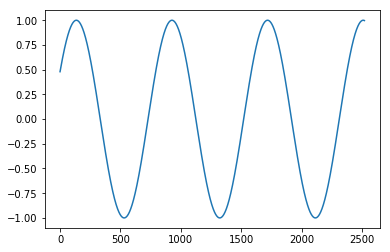

In [36]:
np.random.seed(0)

rand = np.random.random(N)

idx = np.linspace(0, 10, N)
s = pd.Series(1 * np.sin(2 * idx + 0.5))
s.plot()

### (a) Compute the ADF statistic on this series. What is the p-value?
- stationary (p-value = 0)

In [40]:
p_val(s)

0.0

### (b) Shift every observation by the same positive value. Compute the cumulative sum of the observations.
- add 1 to the all values to make them all positive values. Then, cumsum all the values.

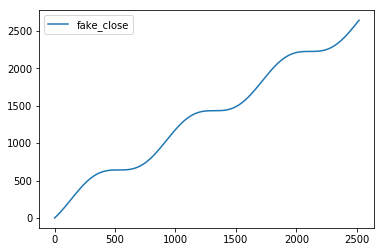

In [43]:
s_ = (s + 1).cumsum().rename('fake_close').to_frame()
s_.plot()

### (i) Compute the ADF statistic on this series. What is the p-value?
- p-value: 0.96

In [48]:
adf(s_['fake_close']), p_val(s_['fake_close'])

((0.08357467652545603,
  0.9649216025751045,
  27,
  2492,
  {'1%': -3.432976825339513,
   '5%': -2.862700515844509,
   '10%': -2.5673877878037974},
  -142669.6207085682),
 0.9649216025751045)

### (ii) Apply an expanding window fractional differenciation, with r = 1E - 2. For what minium d value do you get a p-value below 5%?

In [49]:
def getWeights(d, size):
    # thres > 0 drops insiginificant weights
    w = [1.] 
    for k in range(1, size):
        w_ = -w[-1] * ((d-k+1) / k)
        w.append(w_)
    w = np.array(w[::-1]).reshape(-1,1)
    return w